## Stack Overflow Survey Analysis


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

#preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from scipy import stats

# pipelines
from sklearn.pipeline import Pipeline

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# NLP transformers
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# classifiers you can use
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# model selection bits
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, ShuffleSplit, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn.model_selection import learning_curve, validation_curve

# evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, fbeta_score

In [2]:
df_20 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2020/survey_results_public.csv')
# df_19 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2019/survey_results_public.csv')
# df_18 = pd.read_csv('/Users/bens_mac/Downloads/developer_survey_2018/survey_results_public.csv')
def prettify(ax):
  ax.grid(False)
  ax.set_frame_on(False)
  ax.tick_params(top=False, bottom=False, left=False, right=False, labelbottom=False)

In [3]:
#choosing relevant features from 2020 survey
relevant_data_20 = df_20[['Respondent', 'Country', 'Age1stCode', 'UndergradMajor','Hobbyist', 'Employment','DevType', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'PlatformDesireNextYear', 'PlatformWorkedWith']]

In [4]:
relevant_data_20.head()

,Respondent,Country,Age1stCode,UndergradMajor,Hobbyist,Employment,DevType,DatabaseDesireNextYear,DatabaseWorkedWith,PlatformDesireNextYear,PlatformWorkedWith
0,1,Germany,13,"Computer science, computer engineering, or sof...",Yes,"Independent contractor, freelancer, or self-em...","Developer, desktop or enterprise applications;...",Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows
1,2,United Kingdom,19,"Computer science, computer engineering, or sof...",No,Employed full-time,"Developer, full-stack;Developer, mobile",NaN,NaN,iOS;Kubernetes;Linux;MacOS,iOS
2,3,Russian Federation,15,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Albania,18,"Computer science, computer engineering, or sof...",Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,5,United States,16,"Computer science, computer engineering, or sof...",Yes,Employed full-time,NaN,MySQL;PostgreSQL,MySQL;PostgreSQL;Redis;SQLite,Docker;Google Cloud Platform;Heroku;Linux;Windows,AWS;Docker;Linux;MacOS;Windows


<AxesSubplot:title={'center':'Number of Developers from Countries'}>

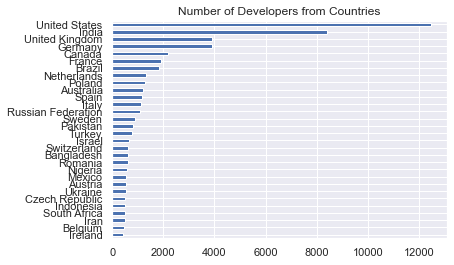

In [81]:
#counting number of developers per country
country_20 = relevant_data_20['Country'].value_counts()
top_country_20 = country_20.head(30).sort_values(ascending = True)
top_country_20.plot(kind = 'barh', title = 'Number of Developers from Countries')

<AxesSubplot:title={'center':'Number of Developers per Devtype'}>

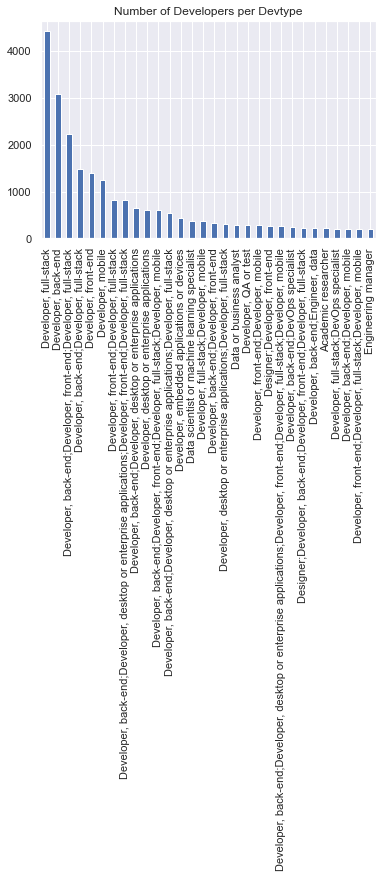

In [114]:
#crosstab Developer types in each top country
devtype_20 = relevant_data_20['DevType'].value_counts()
devtype_20 = devtype_20.head(30).sort_values(ascending = False)
devtype_20.plot(kind = 'bar', title = 'Number of Developers per Devtype')

In [85]:
def split_multicolumn(col_series):
    result_df = col_series.to_frame()
    options = []
    # Iterate over the column
    for idx, value  in col_series[col_series.notnull()].iteritems():
        # Break each value into list of options
        for option in value.split(';'):
            # Add the option as a column to result
            if not option in result_df.columns:
                options.append(option)
                result_df[option] = False
            # Mark the value in the option column as True
            result_df.at[idx, option] = True
    return result_df[options]

In [117]:
devtype_df = split_multicolumn(relevant_data_20['DevType'])

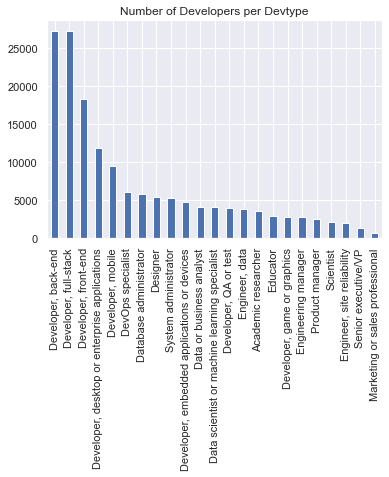

In [128]:
dev_type_totals = devtype_df.sum().sort_values(ascending = False)


from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

pps = dev_type_totals.plot(kind = 'bar', title = 'Number of Developers per Devtype')


plt.show()

In [8]:
'''Taking out NaN's in DevType column while preserving the rest of the 
columns that may also have NaN's in order to get an accurate count of developers per type.'''

dev_types = ['Developer, back-end', 
             'Developer, full-stack', 
             'Developer, front-end', 
             'Developer, desktop or enterprise applications', 
             'Developer, mobile', 
             'DevOps specialist',
             'Database administrator',
             'Designer',
             'System administrator',
             'Developer, embedded applications or devices',
             'Data or business analyst',
             'Data scientist or machine learning specialist',
             'Developer, QA or test',
             'Engineer, data'
            ]

all_devs_df = relevant_data_20.loc[relevant_data_20['DevType'].isin(dev_types)]
all_devs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Respondent              12807 non-null  int64  
 1   Country                 12807 non-null  object 
 2   Age1stCode              12651 non-null  float64
 3   UndergradMajor          11834 non-null  object 
 4   Hobbyist                12807 non-null  object 
 5   Employment              12807 non-null  object 
 6   DevType                 12807 non-null  object 
 7   DatabaseDesireNextYear  8716 non-null   object 
 8   DatabaseWorkedWith      9981 non-null   object 
 9   PlatformDesireNextYear  10131 non-null  object 
 10  PlatformWorkedWith      10881 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.2+ MB


In [152]:
df.Country
# pd.crosstab(df.Country[:148], df.DevType, margins=True, margins_name="Total")
# ct_country_devtype.loc[ct_country_devtype['Country'] == 'United States']

8              Tunisia
16       United States
17       United States
18       United States
19               Spain
             ...      
64429            Spain
64437         Pakistan
64447       Bangladesh
64449     Saudi Arabia
64451           Poland
Name: Country, Length: 12807, dtype: object

In [132]:
pd.crosstab(df['Hobbyist'], df['DevType'])

DevType,Data or business analyst,Data scientist or machine learning specialist,Database administrator,Designer,DevOps specialist,"Developer, QA or test","Developer, back-end","Developer, desktop or enterprise applications","Developer, embedded applications or devices","Developer, front-end","Developer, full-stack","Developer, mobile","Engineer, data",System administrator
Hobbyist,,,,,,,,,,,,,,
No,97,108,9,27,40,93,901,199,117,402,1218,347,49,36
Yes,188,261,30,65,137,192,2185,407,326,999,3206,904,140,124


In [133]:
pd.crosstab(df['DevType'], df['Employment'])

Employment,Employed full-time,Employed part-time,"Independent contractor, freelancer, or self-employed","Not employed, but looking for work"
DevType,,,,
Data or business analyst,246,9,21,9
Data scientist or machine learning specialist,303,21,19,26
Database administrator,28,3,5,3
Designer,62,8,17,5
DevOps specialist,161,7,8,1
"Developer, QA or test",258,9,9,9
"Developer, back-end",2721,99,163,103
"Developer, desktop or enterprise applications",523,29,43,11
"Developer, embedded applications or devices",394,15,22,12


In [10]:
df = pd.concat([all_devs_df, all_devs_df['DatabaseWorkedWith'].str.split(';', expand=True)], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Respondent              12807 non-null  int64  
 1   Country                 12807 non-null  object 
 2   Age1stCode              12651 non-null  float64
 3   UndergradMajor          11834 non-null  object 
 4   Hobbyist                12807 non-null  object 
 5   Employment              12807 non-null  object 
 6   DevType                 12807 non-null  object 
 7   DatabaseDesireNextYear  8716 non-null   object 
 8   DatabaseWorkedWith      9981 non-null   object 
 9   PlatformDesireNextYear  10131 non-null  object 
 10  PlatformWorkedWith      10881 non-null  object 
 11  0                       9981 non-null   object 
 12  1                       6655 non-null   object 
 13  2                       3836 non-null   object 
 14  3                       2008 non-null 

In [12]:
df = df.rename(columns = {0: "CurrentDB0",
                     1: "CurrentDB1",
                     2: "CurrentDB2",
                     3: "CurrentDB3",
                     4: "CurrentDB4", 
                     5:"CurrentDB5",
                     6:"CurrentDB6",
                     7:"CurrentDB7",
                     8:"CurrentDB8",
                     9:"CurrentDB9",
                     10:"CurrentDB10",
                     11:"CurrentDB11",
                     12:"CurrentDB12",
                     13:"CurrentDB13",})

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Respondent              12807 non-null  int64  
 1   Country                 12807 non-null  object 
 2   Age1stCode              12651 non-null  float64
 3   UndergradMajor          11834 non-null  object 
 4   Hobbyist                12807 non-null  object 
 5   Employment              12807 non-null  object 
 6   DevType                 12807 non-null  object 
 7   DatabaseDesireNextYear  8716 non-null   object 
 8   DatabaseWorkedWith      9981 non-null   object 
 9   PlatformDesireNextYear  10131 non-null  object 
 10  PlatformWorkedWith      10881 non-null  object 
 11  CurrentDB0              9981 non-null   object 
 12  CurrentDB1              6655 non-null   object 
 13  CurrentDB2              3836 non-null   object 
 14  CurrentDB3              2008 non-null 

In [14]:
df = pd.concat([df, df['DatabaseDesireNextYear'].str.split(';', expand=True)], axis=1)

In [15]:
df = df.rename(columns = {0: "DesiredDB0",
                     1: "DesiredDB1",
                     2: "DesiredDB2",
                     3: "DesiredDB3",
                     4: "DesiredDB4", 
                     5:"DesiredDB5",
                     6:"DesiredB6",
                     7:"DesiredDB7",
                     8:"DesiredDB8",
                     9:"DesiredDB9",
                     10:"DesiredDB10",
                     11:"DesiredDB11",
                     12:"DesiredDB12",
                     13:"DesiredDB13",})

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Respondent              12807 non-null  int64  
 1   Country                 12807 non-null  object 
 2   Age1stCode              12651 non-null  float64
 3   UndergradMajor          11834 non-null  object 
 4   Hobbyist                12807 non-null  object 
 5   Employment              12807 non-null  object 
 6   DevType                 12807 non-null  object 
 7   DatabaseDesireNextYear  8716 non-null   object 
 8   DatabaseWorkedWith      9981 non-null   object 
 9   PlatformDesireNextYear  10131 non-null  object 
 10  PlatformWorkedWith      10881 non-null  object 
 11  CurrentDB0              9981 non-null   object 
 12  CurrentDB1              6655 non-null   object 
 13  CurrentDB2              3836 non-null   object 
 14  CurrentDB3              2008 non-null 

In [136]:

Developer, full-stack
Developer, back-end
Developer, front-end
Developer, mobile                                1251
Developer, desktop or enterprise applications     606
Developer, embedded applications or devices       443
Data scientist or machine learning specialist     369
Data or business analyst                          285
Developer, QA or test                             285
Engineer, data                                    189
DevOps specialist                                 177
System administrator                              160
Designer                                           92
Database administrator                             39


Developer, full-stack                            4424
Developer, back-end                              3086
Developer, front-end                             1401
Developer, mobile                                1251
Developer, desktop or enterprise applications     606
Developer, embedded applications or devices       443
Data scientist or machine learning specialist     369
Data or business analyst                          285
Developer, QA or test                             285
Engineer, data                                    189
DevOps specialist                                 177
System administrator                              160
Designer                                           92
Database administrator                             39
Name: DevType, dtype: int64

In [17]:
df = pd.concat([df, df['PlatformDesireNextYear'].str.split(';', expand=True)], axis=1)

In [18]:
df = df.rename(columns = {0: "DesiredPlatform0",
                     1: "DesiredPlatform1",
                     2: "DesiredPlatform2",
                     3: "DesiredPlatform3",
                     4: "DesiredPlatform4", 
                     5:"DesiredPlatform5",
                     6:"DesiredPlatform6",
                     7:"DesiredPlatform7",
                     8:"DesiredPlatform8",
                     9:"DesiredPlatform9",
                     10:"DesiredPlatform10",
                     11:"DesiredPlatform11",
                     12:"DesiredPlatform12",
                     13:"DesiredPlatform13",
                    14:"DesiredPlatform14",
                     15:"DesiredPlatform15",                                 
                                                           })

In [19]:
df = pd.concat([df, df['PlatformWorkedWith'].str.split(';', expand=True)], axis=1)

In [20]:
df = df.rename(columns = {0: "CurrentPlatform0",
                     1: "CurrentPlatform1",
                     2: "CurrentPlatform2",
                     3: "CurrentPlatform3",
                     4: "CurrentPlatform4", 
                     5:"CurrentPlatform5",
                     6:"CurrentPlatform6",
                     7:"CurrentPlatform7",
                     8:"CurrentPlatform8",
                     9:"CurrentPlatform9",
                     10:"CurrentPlatform10",
                     11:"CurrentPlatform11",
                     12:"CurrentPlatform12",
                     13:"CurrentPlatform13",
                    14:"CurrentPlatform14",
                     15:"CurrentPlatform15",                                 
                                                           })

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12807 entries, 8 to 64451
Data columns (total 71 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Respondent              12807 non-null  int64  
 1   Country                 12807 non-null  object 
 2   Age1stCode              12651 non-null  float64
 3   UndergradMajor          11834 non-null  object 
 4   Hobbyist                12807 non-null  object 
 5   Employment              12807 non-null  object 
 6   DevType                 12807 non-null  object 
 7   DatabaseDesireNextYear  8716 non-null   object 
 8   DatabaseWorkedWith      9981 non-null   object 
 9   PlatformDesireNextYear  10131 non-null  object 
 10  PlatformWorkedWith      10881 non-null  object 
 11  CurrentDB0              9981 non-null   object 
 12  CurrentDB1              6655 non-null   object 
 13  CurrentDB2              3836 non-null   object 
 14  CurrentDB3              2008 non-null 

In [22]:
df_toy = df[['Country','DevType','CurrentDB0', 'DesiredDB0', 'DesiredPlatform0', 'CurrentPlatform0']]

In [23]:
df_toy.head()

,Country,DevType,CurrentDB0,DesiredDB0,DesiredPlatform0,CurrentPlatform0
8,Tunisia,"Developer, full-stack",NaN,NaN,NaN,WordPress
16,United States,"Developer, full-stack",Microsoft SQL Server,Cassandra,Docker,NaN
17,United States,"Developer, back-end",Elasticsearch,Elasticsearch,Linux,AWS
18,United States,"Developer, full-stack",MariaDB,MariaDB,iOS,Windows
19,Spain,"Developer, desktop or enterprise applications",IBM DB2,NaN,NaN,Heroku


In [25]:
def count_db(df_toy, column_string,db_name):
    '''Count the number of current or desired databases'''
    
    counter = 0
    for i in df_toy[column_string]:
        if i == db_name:
            counter += 1
    return counter

In [129]:
Cur_MySQL = count_db(df_toy, "CurrentDB0","MySQL")
Cur_PostgreSQL = count_db(df_toy, "CurrentDB0","PostgreSQL")
Cur_Microsoft_SQL_Server = count_db(df_toy, "CurrentDB0","Microsoft SQL Server")
Cur_SQLite = count_db(df_toy, "CurrentDB0","SQLite")
Cur_MongoDB = count_db(df_toy, "CurrentDB0","MongoDB")
Cur_Redis = count_db(df_toy, "CurrentDB0","Redis")
Cur_MariaDB = count_db(df_toy, "CurrentDB0","MariaDB")
Cur_Oracle = count_db(df_toy, "CurrentDB0","Oracle")
Cur_Firebase = count_db(df_toy, "CurrentDB0","Firebase")
Cur_Elasticsearch = count_db(df_toy, "CurrentDB0","Elasticsearch")
Cur_DynamoDB = count_db(df_toy, "CurrentDB0","DynamoDB")
Cur_Cassandra = count_db(df_toy, "CurrentDB0","Cassandra")
Cur_IBM_DB2 = count_db(df_toy, "CurrentDB0","IBM DB2")
Cur_Couchbase= count_db(df_toy, "CurrentDB0","Couchbase")

Current_DBs = [
Cur_MySQL,
Cur_PostgreSQL,
Cur_Microsoft_SQL_Server,
Cur_SQLite,
Cur_MongoDB,
Cur_Redis,
Cur_MariaDB,
Cur_Oracle,
Cur_Firebase,
Cur_Elasticsearch,
Cur_DynamoDB,
Cur_Cassandra,
Cur_IBM_DB2,
Cur_Couchbase
]

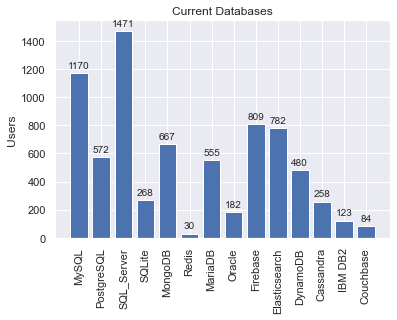

In [27]:
labels = ['MySQL',
'PostgreSQL',
'SQL_Server',
'SQLite',
'MongoDB',
"Redis",
"MariaDB",
"Oracle",
"Firebase",
"Elasticsearch",
"DynamoDB",
"Cassandra",
"IBM DB2",
"Couchbase"
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Current Databases')

# ax.bar(x - width/2, Current_DBs, width, label='Current_DBs')

pps = plt.bar(labels,Current_DBs)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [28]:
Des_MySQL = count_db(df_toy, "DesiredDB0","MySQL")
Des_PostgreSQL = count_db(df_toy, "DesiredDB0","PostgreSQL")
Des_Microsoft_SQL_Server = count_db(df_toy, "DesiredDB0","Microsoft SQL Server")
Des_SQLite = count_db(df_toy, "DesiredDB0","SQLite")
Des_MongoDB = count_db(df_toy, "DesiredDB0","MongoDB")
Des_Redis = count_db(df_toy, "DesiredDB0","Redis")
Des_MariaDB = count_db(df_toy, "DesiredDB0","MariaDB")
Des_Oracle = count_db(df_toy, "DesiredDB0","Oracle")
Des_Firebase = count_db(df_toy, "DesiredDB0","Firebase")
Des_Elasticsearch = count_db(df_toy, "DesiredDB0","Elasticsearch")
Des_DynamoDB = count_db(df_toy, "DesiredDB0","DynamoDB")
Des_Cassandra = count_db(df_toy, "DesiredDB0","Cassandra")
Des_IBM_DB2 = count_db(df_toy, "DesiredDB0","IBM DB2")
Des_Couchbase= count_db(df_toy, "DesiredDB0","Couchbase")

Desired_DBs = [
Des_MySQL,
Des_PostgreSQL,
Des_Microsoft_SQL_Server,
Des_SQLite,
Des_MongoDB,
Des_Redis,
Des_MariaDB,
Des_Oracle,
Des_Firebase,
Des_Elasticsearch,
Des_DynamoDB,
Des_Cassandra,
Des_IBM_DB2,
Des_Couchbase
]

sum = 0
for i in Desired_DBs:
    sum += i
print(sum)

7451


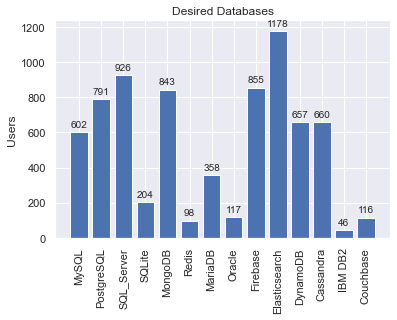

In [29]:
labels = ['MySQL',
'PostgreSQL',
'SQL_Server',
'SQLite',
'MongoDB',
"Redis",
"MariaDB",
"Oracle",
"Firebase",
"Elasticsearch",
"DynamoDB",
"Cassandra",
"IBM DB2",
"Couchbase"
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Desired Databases')

pps = plt.bar(labels,Desired_DBs)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [30]:
def count_platforms(df_toy, column_string,platform_name):
    '''Count the number of desired platforms'''
    
    counter = 0
    for i in df_toy[column_string]:
        if i == platform_name:
            counter += 1
    return counter


In [31]:
Linux = count_platforms(df_toy, "DesiredPlatform0","Linux")
Windows = count_platforms(df_toy, "DesiredPlatform0","Windows")
Docker = count_platforms(df_toy, "DesiredPlatform0","Docker")
AWS = count_platforms(df_toy, "DesiredPlatform0","AWS")
Android = count_platforms(df_toy, "DesiredPlatform0","Android")
MacOS = count_platforms(df_toy, "DesiredPlatform0","MacOS")
Raspberry_Pi = count_platforms(df_toy, "DesiredPlatform0","Raspberry Pi")
Azure = count_platforms(df_toy, "DesiredPlatform0","Microsoft Azure")
WordPress = count_platforms(df_toy, "DesiredPlatform0","WordPress")
Google = count_platforms(df_toy, "DesiredPlatform0","Google Cloud Platform")
iOS = count_platforms(df_toy, "DesiredPlatform0","iOS")
Kubernetes = count_platforms(df_toy, "DesiredPlatform0","Kubernetes")
Heroku = count_platforms(df_toy, "DesiredPlatform0","Heroku")
Arduino= count_platforms(df_toy, "DesiredPlatform0","Arduino")
Slack = count_platforms(df_toy, "DesiredPlatform0","Slack Apps and Integrations")
Watson= count_platforms(df_toy, "DesiredPlatform0","IBM Cloud or Watson")

Desired_Platforms = [
Linux,
Windows,
Docker,
AWS,
Android,
MacOS,
Raspberry_Pi,
Azure,
WordPress,
Google,
iOS,
Kubernetes,
Heroku,
Arduino,
Slack,
Watson
]

sum = 0
for i in Desired_Platforms:
    sum += i
print(sum)


7451


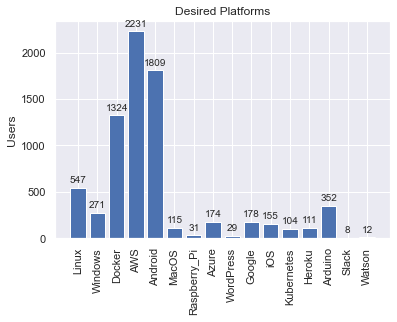

In [32]:
labels = [
'Linux',
'Windows',
'Docker',
'AWS',
'Android',
'MacOS',
'Raspberry_Pi',
'Azure',
'WordPress',
'Google',
'iOS',
'Kubernetes',
'Heroku',
'Arduino',
'Slack',
'Watson'
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Desired Platforms')

pps = plt.bar(labels,Desired_Platforms)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [33]:
#PlatformWorkedWith0

Linux = count_platforms(df_toy, "CurrentPlatform0","Linux")
Windows = count_platforms(df_toy, "CurrentPlatform0","Windows")
Docker = count_platforms(df_toy, "CurrentPlatform0","Docker")
AWS = count_platforms(df_toy, "CurrentPlatform0","AWS")
Android = count_platforms(df_toy, "CurrentPlatform0","Android")
MacOS = count_platforms(df_toy, "CurrentPlatform0","MacOS")
Raspberry_Pi = count_platforms(df_toy, "CurrentPlatform0","Raspberry Pi")
Azure = count_platforms(df_toy, "CurrentPlatform0","Microsoft Azure")
WordPress = count_platforms(df_toy, "CurrentPlatform0","WordPress")
Google = count_platforms(df_toy, "CurrentPlatform0","Google Cloud Platform")
iOS = count_platforms(df_toy, "CurrentPlatform0","iOS")
Kubernetes = count_platforms(df_toy, "CurrentPlatform0","Kubernetes")
Heroku = count_platforms(df_toy, "CurrentPlatform0","Heroku")
Arduino= count_platforms(df_toy, "CurrentPlatform0","Arduino")
Slack = count_platforms(df_toy, "CurrentPlatform0","Slack Apps and Integrations")
Watson= count_platforms(df_toy, "CurrentPlatform0","IBM Cloud or Watson")

Current_Platforms = [
Linux,
Windows,
Docker,
AWS,
Android,
MacOS,
Raspberry_Pi,
Azure,
WordPress,
Google,
iOS,
Kubernetes,
Heroku,
Arduino,
Slack,
Watson
]

sum = 0
for i in Current_Platforms:
    sum += i
print(sum)

7451


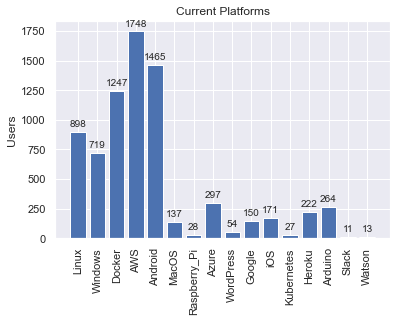

In [34]:
labels = [
'Linux',
'Windows',
'Docker',
'AWS',
'Android',
'MacOS',
'Raspberry_Pi',
'Azure',
'WordPress',
'Google',
'iOS',
'Kubernetes',
'Heroku',
'Arduino',
'Slack',
'Watson'
         ]
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

plt.xticks(rotation=90,wrap=False)

# plt.figure(figsize=(11,8))

ax.set_ylabel('Users')
ax.set_title('Current Platforms')

pps = plt.bar(labels,Current_Platforms)
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')


plt.show()

In [52]:
#One-hot encoding and training dataset for predicting desired databases

X_database = pd.get_dummies(df_toy, columns= ['DevType','CurrentDB0', 'DesiredPlatform0','CurrentPlatform0'])
X_database = X_database.drop(['Country', 'DesiredDB0'], axis = 1)

In [53]:
#Labels for top desired databases


def desired_database_y(df_toy, column_string, label):
    
    label_name = []
    for i in df_toy[column_string]:
        if i == label:
            label_name.append(1)
        else:
            label_name.append(0) 
    return label_name

MySQL_y = (desired_database_y(df_toy, 'DesiredDB0', "MySQL"))
Elasticsearch_y = (desired_database_y(df_toy, 'DesiredDB0', "Elasticsearch"))
SQL_Server_y = (desired_database_y(df_toy, 'DesiredDB0', "SQL_Server"))
PostgreSQL_y = (desired_database_y(df_toy, 'DesiredDB0', "PostgreSQL"))
Firebase_y = (desired_database_y(df_toy, 'DesiredDB0', "Firebase"))
DynamoDB_y = (desired_database_y(df_toy, 'DesiredDB0', "DynamoDB"))
np.count_nonzero(Elasticsearch_y)

1178

In [79]:
#Choose a Desired platform to test


# y_label = Azure_y
        
# X_train, X_test, y_train, y_test = train_test_split(X,y_label, test_size = .2)
# clf = DecisionTreeClassifier()
# cv = StratifiedKFold(n_splits = 5) 
# scores = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = cv)
# print(scores.mean())



#Create function to make it easier to calculate means for accuracy scores for top labels.

def mean_accuracy_scores(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2)
    clf = DecisionTreeClassifier()
    cv = StratifiedKFold(n_splits = 10) 
    scores = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = cv)
    return scores.mean()

print(f"MySQL accuracy score: {mean_accuracy_scores(X_database, MySQL_y)}")
print(f"Elastic accuracy score: {mean_accuracy_scores(X_database, Elasticsearch_y)}")
print(f"SQL Server accuracy score: {mean_accuracy_scores(X_database, SQL_Server_y)}")
print(f"PostgresSQL accuracy score: {mean_accuracy_scores(X_database, PostgreSQL_y)}")
print(f"Firebase accuracy score: {mean_accuracy_scores(X_database, Firebase_y)}")
print(f"DynamoDB accuracy score: {mean_accuracy_scores(X_database, DynamoDB_y)}")




MySQL accuracy score: 0.9137583892617449
Elastic accuracy score: 0.8191275167785234
SQL Server accuracy score: 1.0
PostgresSQL accuracy score: 0.8976510067114093
Firebase accuracy score: 0.9033557046979865
DynamoDB accuracy score: 0.9211409395973155


In [62]:
#visualize Decision Tree:

from sklearn import tree

y = Elasticsearch_y

X_train, X_test, y_train, y_test = train_test_split(X_database,y, test_size = .2)

clf = tree.DecisionTreeClassifier(random_state=0)

clf = clf.fit(X_train, y_train)

# fig = plt.figure(figsize=(25,20))
# tree.plot_tree(clf, filled = True, rounded = True)

In [64]:
# Extract Column Names as List in Pandas Dataframe

predictor_names = X_database.columns.tolist()

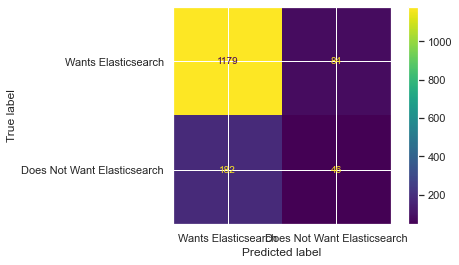

In [66]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test, display_labels= ["Wants Elasticsearch", "Does Not Want Elasticsearch"])

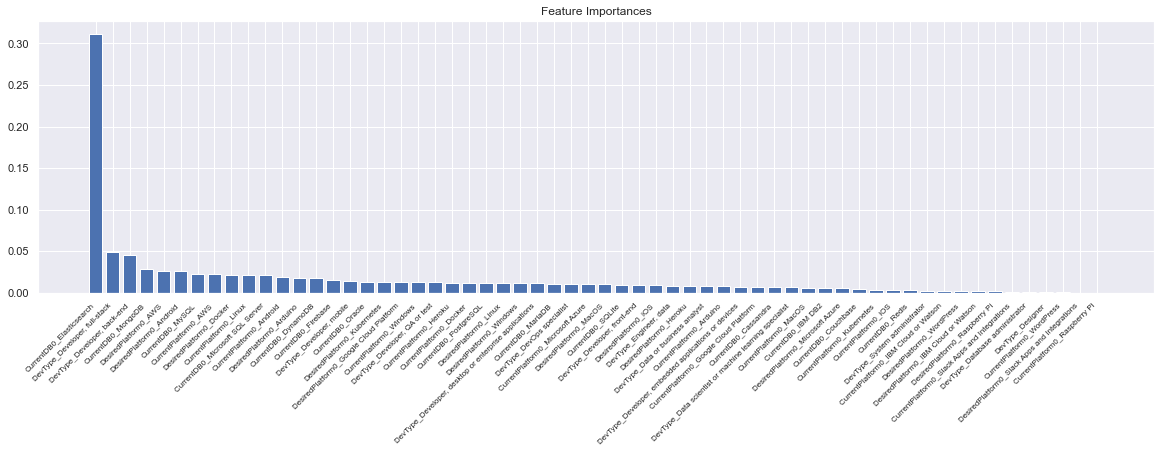

In [68]:
'''Determine most important features. Decision trees make splits that maximize the decrease in impurity. 
By calculating the mean decrease in impurity for each feature across all trees we can know that 
feature's importance.'''

importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

f_names = [predictor_names[i] for i in indices]

#create my plot
fig, axes = plt.subplots(figsize=(20,5))
axes.set_title("Feature Importances")
axes.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
axes.set_xticks(range(X_database.shape[1]));
axes.set_xticklabels(f_names, rotation=45, ha='right', fontsize = '8');

In [71]:
path = clf.cost_complexity_pruning_path(X_train, y_train) # determine values of alpha
ccp_alphas = path.ccp_alphas #extract different values for alpha
cc_alphas = ccp_alphas[:-1] # exclude the max value for alpha

clf_dts = [] #create an array for decision trees

## create one decision tree per value for alpha and store it in the array

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

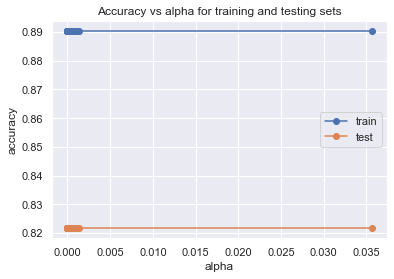

In [78]:
train_scores = [clf.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker = 'o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker = 'o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()